# Predicting Brand Exposure

## 02_Build Models
* Load in data from previous steps
* Train and Evaluate various models
    * <strong>Try Some Regression Models and compare performance</strong>
        * Random Forest Regressor
        * SVR Support Vector Regression
        * MLP with last layer fully connected, no activation
            * [Update] Due to a small dataset, it is proving difficult to train this MLP. 
    * <strong>Try converting the Weekly Count traget feature to a categorical label and model with a classification algorithm</strong>        
        * Random Forest Classification
        * SVM
        * MLP with softmax activation on final layer  
          
* Identify model that performs best and save for future use

## Import and Load Data

In [2]:
import pandas as pd
import numpy as np

df = pd.read_excel('../data_archives/df_processed.xlsx')

In [3]:
#inspect data
df.head()

,index,name,lat,long,google_id,venue_type,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,WeekTotals,mapped_venue_type,activity_cluster
0,0,"McMahon & Associates, PC",42.352366,-71.056066,ChIJddqFA4Jw44kRHz6p3qWTs4c,"['accounting', 'lawyer', 'finance', 'point_of_...",443,531,506,519,514,144,40,2697,finance,2
1,1,"Barclay Damon, LLP",42.352321,-71.056248,ChIJD75e1YBw44kRvDZoMEj44jY,"['accounting', 'lawyer', 'finance', 'point_of_...",443,531,506,519,514,144,40,2697,finance,2
2,2,Request Health Corporation,42.351584,-71.056269,ChIJv1J9rnh644kR4hc29XVaEFg,"['accounting', 'finance', 'point_of_interest',...",443,531,506,519,514,144,40,2697,finance,2
3,3,StackUp,42.351586,-71.056323,ChIJY_v-pXh744kRub1hj4RNwkk,"['accounting', 'finance', 'point_of_interest',...",443,531,506,519,514,144,40,2697,finance,2
4,4,KPMG,42.351781,-71.056737,ChIJDaRRe4Jw44kRjXWBXIsFgj0,"['accounting', 'finance', 'point_of_interest',...",443,531,506,519,514,144,40,2697,finance,2


## Prepare Train, Test, and Validation Data

In [4]:
from sklearn.preprocessing import MinMaxScaler
from keras.utils import to_categorical
from pandas import get_dummies



#split data into features and labels
X = df[df['WeekTotals']>0][['lat','long','mapped_venue_type','activity_cluster']]
y = df[df['WeekTotals']>0]['WeekTotals']

#normalize lat and long
scaler = MinMaxScaler()
scaler.fit(X[['lat','long']])
X[['lat','long']] = scaler.transform(X[['lat','long']])

#encode categorical variable
X = pd.get_dummies(X, columns=["mapped_venue_type"])

#convert to array
X = np.array(X)
y = np.array(y)

Using TensorFlow backend.


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42,shuffle=True)

## Build Random Forest

In [37]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import numpy as np

In [38]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [39]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
#define parameters to search
param_grid = {
    'n_estimators': [10,20,30,40,50,100],
    'max_features':[9,10,11,12,13,14,15],
    'max_depth':[40,45,50,75,100],
    'min_samples_split':[40,45,50,55,60]
}

#create regressor object
regr = RandomForestRegressor(min_samples_leaf=2,criterion='mse',random_state=2222)
#create grid search object
grid_search = GridSearchCV(estimator = regr, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 1)
#fit grid search object
grid_search.fit(X_train, y_train)
print("========================================")
print("Finished training")
print("========================================")
print("Parameters of best estimator...")
best_grid = grid_search.best_estimator_
print(grid_search.best_params_)
print("========================================")
print("Best estimator accuracy...")
grid_accuracy = evaluate(best_grid, X_test, y_test)
print(grid_accuracy)

Fitting 3 folds for each of 1050 candidates, totalling 3150 fits


[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 1192 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 2692 tasks      | elapsed:   38.3s


Finished training
Parameters of best estimator...
{'max_depth': 40, 'max_features': 9, 'min_samples_split': 50, 'n_estimators': 40}
Best estimator accuracy...
Model Performance
Average Error: 261.9541 degrees.
Accuracy = 89.76%.
89.7576732048


[Parallel(n_jobs=-1)]: Done 3150 out of 3150 | elapsed:   44.6s finished


#### Random Forest Performance: 64.92%

#### Random Forest performance increased to 89.76% after incorporating synthetic data generated using PCA and KMeans Clustering

## SVR - Support Vector Regression

In [40]:
#import libraries
from sklearn.svm import SVR

In [41]:
#create svr object
svr = SVR()

#define parameter grid
svr_param_grid = {
    'C': np.arange(1.0,4.0,1.0),
    'epsilon':np.arange(0.1,1.0,0.1),
    'kernel':['linear','poly','rbf','sigmoid'],
    'degree':range(2,6,1),
    'gamma':['auto'],
    'max_iter':[1000]
}

#create grid search object
grid_search_svr = GridSearchCV(estimator=svr, param_grid=svr_param_grid, cv=3, n_jobs=-1, verbose=1)
#fit the grid search object
grid_search_svr.fit(X_train, y_train)

print("========================================")
print("Finished training")
print("========================================")
print("Parameters of best estimator...")
svr_best_grid = grid_search_svr.best_estimator_
print(grid_search_svr.best_params_)
print("========================================")
print("Best estimator accuracy...")
svr_grid_accuracy = evaluate(svr_best_grid, X_test, y_test)
print(svr_grid_accuracy)

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    1.8s
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScale

Finished training
Parameters of best estimator...
{'C': 3.0, 'degree': 2, 'epsilon': 0.90000000000000002, 'gamma': 'auto', 'kernel': 'linear', 'max_iter': 1000}
Best estimator accuracy...
Model Performance
Average Error: 384.4563 degrees.
Accuracy = 89.03%.
89.0274101464


[Parallel(n_jobs=-1)]: Done 1296 out of 1296 | elapsed:   12.1s finished


#### SVR Performance: 68.98%

#### SVR performance increased to 89.03% after incorporating synthetic data generated using PCA and KMeans Clustering

## MLP Regression

In [42]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import optimizers
import numpy as np

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42,shuffle=True)

In [49]:
mlp_model = Sequential()
mlp_model.add(Dense(17,activation='linear',input_shape=(17,)))
mlp_model.add(Dense(32, activation='linear'))
mlp_model.add(Dropout(rate=0.1))
mlp_model.add(Dense(64, activation='linear'))
mlp_model.add(Dropout(rate=0.1))
mlp_model.add(Dense(128, activation='linear'))
mlp_model.add(Dropout(rate=0.1))
mlp_model.add(Dense(1))
mlp_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 17)                306       
_________________________________________________________________
dense_16 (Dense)             (None, 32)                576       
_________________________________________________________________
dropout_9 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)               0         
__________

In [50]:
#compile model
loss = 'mean_absolute_error'
optimizer = 'adam'
metrics=['mae','acc']

mlp_model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [51]:
#train model
#earlystop = EarlyStopping(monitor='val_mean_absolute_error',min_delta=0.1, patience=5)
checkpoint = ModelCheckpoint('./saved_models/mlp_regression/mlp_regression.best.hdf5',
                             monitor='acc',save_best_only=True,)

epochs = 1000

model_hist = mlp_model.fit(X_train,y_train,
                       epochs=epochs,verbose=2,callbacks=[checkpoint],
                       validation_split=.1,shuffle=True,steps_per_epoch=100,validation_steps=20)

#validation_data=(X_test,y_test),

Train on 1240 samples, validate on 138 samples
Epoch 1/1000
 - 1s - loss: 2250.2404 - mean_absolute_error: 2250.2404 - acc: 4.8387e-05 - val_loss: 834.2276 - val_mean_absolute_error: 834.2276 - val_acc: 0.0000e+00
Epoch 2/1000
 - 0s - loss: 551.6973 - mean_absolute_error: 551.6973 - acc: 7.9839e-04 - val_loss: 354.3269 - val_mean_absolute_error: 354.3269 - val_acc: 0.0000e+00
Epoch 3/1000
 - 0s - loss: 403.7469 - mean_absolute_error: 403.7469 - acc: 0.0013 - val_loss: 258.5392 - val_mean_absolute_error: 258.5392 - val_acc: 0.0072
Epoch 4/1000
 - 0s - loss: 368.1701 - mean_absolute_error: 368.1701 - acc: 0.0015 - val_loss: 233.6499 - val_mean_absolute_error: 233.6499 - val_acc: 0.0145
Epoch 5/1000
 - 0s - loss: 352.8145 - mean_absolute_error: 352.8145 - acc: 0.0015 - val_loss: 216.1812 - val_mean_absolute_error: 216.1812 - val_acc: 0.0000e+00
Epoch 6/1000
 - 0s - loss: 338.5461 - mean_absolute_error: 338.5461 - acc: 0.0018 - val_loss: 192.2841 - val_mean_absolute_error: 192.2841 - val_a

Epoch 53/1000
 - 1s - loss: 278.4458 - mean_absolute_error: 278.4458 - acc: 0.0025 - val_loss: 159.2966 - val_mean_absolute_error: 159.2966 - val_acc: 0.0072
Epoch 54/1000
 - 1s - loss: 278.9780 - mean_absolute_error: 278.9780 - acc: 0.0026 - val_loss: 162.9785 - val_mean_absolute_error: 162.9785 - val_acc: 0.0145
Epoch 55/1000
 - 0s - loss: 278.2406 - mean_absolute_error: 278.2406 - acc: 0.0029 - val_loss: 158.2666 - val_mean_absolute_error: 158.2666 - val_acc: 0.0507
Epoch 56/1000
 - 0s - loss: 278.0947 - mean_absolute_error: 278.0947 - acc: 0.0026 - val_loss: 160.3817 - val_mean_absolute_error: 160.3817 - val_acc: 0.0000e+00
Epoch 57/1000
 - 0s - loss: 278.1980 - mean_absolute_error: 278.1980 - acc: 0.0026 - val_loss: 158.5143 - val_mean_absolute_error: 158.5143 - val_acc: 0.0000e+00
Epoch 58/1000
 - 1s - loss: 277.9215 - mean_absolute_error: 277.9215 - acc: 0.0026 - val_loss: 166.5495 - val_mean_absolute_error: 166.5495 - val_acc: 0.0145
Epoch 59/1000
 - 1s - loss: 278.1449 - mean_

Epoch 105/1000
 - 0s - loss: 273.3649 - mean_absolute_error: 273.3649 - acc: 0.0027 - val_loss: 157.0310 - val_mean_absolute_error: 157.0310 - val_acc: 0.0362
Epoch 106/1000
 - 0s - loss: 273.8359 - mean_absolute_error: 273.8359 - acc: 0.0028 - val_loss: 164.0582 - val_mean_absolute_error: 164.0582 - val_acc: 0.0000e+00
Epoch 107/1000
 - 0s - loss: 273.5244 - mean_absolute_error: 273.5244 - acc: 0.0026 - val_loss: 164.7807 - val_mean_absolute_error: 164.7807 - val_acc: 0.0145
Epoch 108/1000
 - 1s - loss: 273.2698 - mean_absolute_error: 273.2698 - acc: 0.0028 - val_loss: 159.1417 - val_mean_absolute_error: 159.1417 - val_acc: 0.0145
Epoch 109/1000
 - 1s - loss: 272.8592 - mean_absolute_error: 272.8592 - acc: 0.0026 - val_loss: 157.1523 - val_mean_absolute_error: 157.1523 - val_acc: 0.0652
Epoch 110/1000
 - 1s - loss: 272.9238 - mean_absolute_error: 272.9238 - acc: 0.0026 - val_loss: 160.3605 - val_mean_absolute_error: 160.3605 - val_acc: 0.0217
Epoch 111/1000
 - 1s - loss: 272.7484 - me

Epoch 157/1000
 - 0s - loss: 265.3750 - mean_absolute_error: 265.3750 - acc: 0.0032 - val_loss: 155.6915 - val_mean_absolute_error: 155.6915 - val_acc: 0.0217
Epoch 158/1000
 - 0s - loss: 264.7112 - mean_absolute_error: 264.7112 - acc: 0.0029 - val_loss: 165.5858 - val_mean_absolute_error: 165.5858 - val_acc: 0.0072
Epoch 159/1000
 - 1s - loss: 265.0680 - mean_absolute_error: 265.0680 - acc: 0.0030 - val_loss: 161.1815 - val_mean_absolute_error: 161.1815 - val_acc: 0.0000e+00
Epoch 160/1000
 - 1s - loss: 264.6961 - mean_absolute_error: 264.6961 - acc: 0.0032 - val_loss: 159.2386 - val_mean_absolute_error: 159.2386 - val_acc: 0.0072
Epoch 161/1000
 - 1s - loss: 264.4201 - mean_absolute_error: 264.4201 - acc: 0.0031 - val_loss: 155.7320 - val_mean_absolute_error: 155.7320 - val_acc: 0.0797
Epoch 162/1000
 - 1s - loss: 264.1253 - mean_absolute_error: 264.1253 - acc: 0.0033 - val_loss: 161.6409 - val_mean_absolute_error: 161.6409 - val_acc: 0.0217
Epoch 163/1000
 - 1s - loss: 263.8146 - me

Epoch 209/1000
 - 0s - loss: 253.8229 - mean_absolute_error: 253.8229 - acc: 0.0038 - val_loss: 158.3614 - val_mean_absolute_error: 158.3614 - val_acc: 0.0145
Epoch 210/1000
 - 0s - loss: 253.2373 - mean_absolute_error: 253.2373 - acc: 0.0036 - val_loss: 155.9335 - val_mean_absolute_error: 155.9335 - val_acc: 0.0072
Epoch 211/1000
 - 0s - loss: 252.9071 - mean_absolute_error: 252.9071 - acc: 0.0036 - val_loss: 162.1333 - val_mean_absolute_error: 162.1333 - val_acc: 0.0000e+00
Epoch 212/1000
 - 0s - loss: 252.7195 - mean_absolute_error: 252.7195 - acc: 0.0040 - val_loss: 162.3966 - val_mean_absolute_error: 162.3966 - val_acc: 0.0217
Epoch 213/1000
 - 0s - loss: 252.5576 - mean_absolute_error: 252.5576 - acc: 0.0038 - val_loss: 158.9254 - val_mean_absolute_error: 158.9254 - val_acc: 0.0217
Epoch 214/1000
 - 0s - loss: 251.8279 - mean_absolute_error: 251.8279 - acc: 0.0038 - val_loss: 154.4627 - val_mean_absolute_error: 154.4627 - val_acc: 0.1377
Epoch 215/1000
 - 0s - loss: 251.7642 - me

Epoch 261/1000
 - 0s - loss: 247.7588 - mean_absolute_error: 247.7588 - acc: 0.0040 - val_loss: 158.8764 - val_mean_absolute_error: 158.8764 - val_acc: 0.0217
Epoch 262/1000
 - 0s - loss: 247.6591 - mean_absolute_error: 247.6591 - acc: 0.0038 - val_loss: 159.9978 - val_mean_absolute_error: 159.9978 - val_acc: 0.0217
Epoch 263/1000
 - 0s - loss: 247.3952 - mean_absolute_error: 247.3952 - acc: 0.0045 - val_loss: 157.9847 - val_mean_absolute_error: 157.9847 - val_acc: 0.0000e+00
Epoch 264/1000
 - 0s - loss: 246.9699 - mean_absolute_error: 246.9699 - acc: 0.0039 - val_loss: 167.5683 - val_mean_absolute_error: 167.5683 - val_acc: 0.0652
Epoch 265/1000
 - 0s - loss: 247.6349 - mean_absolute_error: 247.6349 - acc: 0.0040 - val_loss: 155.0448 - val_mean_absolute_error: 155.0448 - val_acc: 0.0145
Epoch 266/1000
 - 0s - loss: 247.4149 - mean_absolute_error: 247.4149 - acc: 0.0040 - val_loss: 155.5840 - val_mean_absolute_error: 155.5840 - val_acc: 0.0290
Epoch 267/1000
 - 0s - loss: 247.3977 - me

Epoch 313/1000
 - 0s - loss: 246.8868 - mean_absolute_error: 246.8868 - acc: 0.0041 - val_loss: 155.0223 - val_mean_absolute_error: 155.0223 - val_acc: 0.0000e+00
Epoch 314/1000
 - 0s - loss: 246.5745 - mean_absolute_error: 246.5745 - acc: 0.0037 - val_loss: 157.2500 - val_mean_absolute_error: 157.2500 - val_acc: 0.0797
Epoch 315/1000
 - 0s - loss: 246.5197 - mean_absolute_error: 246.5197 - acc: 0.0041 - val_loss: 154.6638 - val_mean_absolute_error: 154.6638 - val_acc: 0.0000e+00
Epoch 316/1000
 - 0s - loss: 246.1703 - mean_absolute_error: 246.1703 - acc: 0.0040 - val_loss: 158.8796 - val_mean_absolute_error: 158.8796 - val_acc: 0.0072
Epoch 317/1000
 - 0s - loss: 246.8409 - mean_absolute_error: 246.8409 - acc: 0.0039 - val_loss: 166.8786 - val_mean_absolute_error: 166.8786 - val_acc: 0.0145
Epoch 318/1000
 - 0s - loss: 246.6483 - mean_absolute_error: 246.6483 - acc: 0.0041 - val_loss: 168.2871 - val_mean_absolute_error: 168.2871 - val_acc: 0.0000e+00
Epoch 319/1000
 - 0s - loss: 246.7

Epoch 365/1000
 - 0s - loss: 246.5755 - mean_absolute_error: 246.5755 - acc: 0.0042 - val_loss: 160.8197 - val_mean_absolute_error: 160.8197 - val_acc: 0.0072
Epoch 366/1000
 - 0s - loss: 246.6481 - mean_absolute_error: 246.6481 - acc: 0.0042 - val_loss: 166.4874 - val_mean_absolute_error: 166.4874 - val_acc: 0.0217
Epoch 367/1000
 - 0s - loss: 246.6615 - mean_absolute_error: 246.6615 - acc: 0.0039 - val_loss: 164.8971 - val_mean_absolute_error: 164.8971 - val_acc: 0.0000e+00
Epoch 368/1000
 - 0s - loss: 246.6786 - mean_absolute_error: 246.6786 - acc: 0.0041 - val_loss: 154.6284 - val_mean_absolute_error: 154.6284 - val_acc: 0.0507
Epoch 369/1000
 - 0s - loss: 246.6264 - mean_absolute_error: 246.6264 - acc: 0.0041 - val_loss: 162.5088 - val_mean_absolute_error: 162.5088 - val_acc: 0.0072
Epoch 370/1000
 - 0s - loss: 246.4084 - mean_absolute_error: 246.4084 - acc: 0.0041 - val_loss: 154.3109 - val_mean_absolute_error: 154.3109 - val_acc: 0.0290
Epoch 371/1000
 - 0s - loss: 246.7271 - me

Epoch 417/1000
 - 0s - loss: 245.7962 - mean_absolute_error: 245.7962 - acc: 0.0045 - val_loss: 154.9665 - val_mean_absolute_error: 154.9665 - val_acc: 0.0217
Epoch 418/1000
 - 0s - loss: 245.7654 - mean_absolute_error: 245.7654 - acc: 0.0045 - val_loss: 159.3275 - val_mean_absolute_error: 159.3275 - val_acc: 0.0000e+00
Epoch 419/1000
 - 0s - loss: 246.4636 - mean_absolute_error: 246.4636 - acc: 0.0038 - val_loss: 159.0251 - val_mean_absolute_error: 159.0251 - val_acc: 0.0217
Epoch 420/1000
 - 0s - loss: 246.8429 - mean_absolute_error: 246.8429 - acc: 0.0041 - val_loss: 155.7584 - val_mean_absolute_error: 155.7584 - val_acc: 0.0072
Epoch 421/1000
 - 0s - loss: 246.9177 - mean_absolute_error: 246.9177 - acc: 0.0040 - val_loss: 156.8760 - val_mean_absolute_error: 156.8760 - val_acc: 0.0870
Epoch 422/1000
 - 0s - loss: 246.1815 - mean_absolute_error: 246.1815 - acc: 0.0042 - val_loss: 160.5313 - val_mean_absolute_error: 160.5313 - val_acc: 0.0145
Epoch 423/1000
 - 0s - loss: 245.9434 - me

Epoch 469/1000
 - 0s - loss: 246.0382 - mean_absolute_error: 246.0382 - acc: 0.0045 - val_loss: 161.2998 - val_mean_absolute_error: 161.2998 - val_acc: 0.0072
Epoch 470/1000
 - 0s - loss: 246.2561 - mean_absolute_error: 246.2561 - acc: 0.0041 - val_loss: 159.4036 - val_mean_absolute_error: 159.4036 - val_acc: 0.0000e+00
Epoch 471/1000
 - 0s - loss: 245.6055 - mean_absolute_error: 245.6055 - acc: 0.0043 - val_loss: 155.5558 - val_mean_absolute_error: 155.5558 - val_acc: 0.0942
Epoch 472/1000
 - 0s - loss: 245.6804 - mean_absolute_error: 245.6804 - acc: 0.0040 - val_loss: 152.9146 - val_mean_absolute_error: 152.9146 - val_acc: 0.1377
Epoch 473/1000
 - 0s - loss: 245.8385 - mean_absolute_error: 245.8385 - acc: 0.0044 - val_loss: 160.3497 - val_mean_absolute_error: 160.3497 - val_acc: 0.0507
Epoch 474/1000
 - 0s - loss: 246.3574 - mean_absolute_error: 246.3574 - acc: 0.0040 - val_loss: 154.5812 - val_mean_absolute_error: 154.5812 - val_acc: 0.0145
Epoch 475/1000
 - 1s - loss: 246.1917 - me

Epoch 521/1000
 - 0s - loss: 245.9594 - mean_absolute_error: 245.9594 - acc: 0.0044 - val_loss: 154.7714 - val_mean_absolute_error: 154.7714 - val_acc: 0.0072
Epoch 522/1000
 - 0s - loss: 245.8561 - mean_absolute_error: 245.8561 - acc: 0.0040 - val_loss: 153.9244 - val_mean_absolute_error: 153.9244 - val_acc: 0.0435
Epoch 523/1000
 - 0s - loss: 246.2467 - mean_absolute_error: 246.2467 - acc: 0.0040 - val_loss: 153.3470 - val_mean_absolute_error: 153.3470 - val_acc: 0.0217
Epoch 524/1000
 - 0s - loss: 246.1455 - mean_absolute_error: 246.1455 - acc: 0.0041 - val_loss: 156.2665 - val_mean_absolute_error: 156.2665 - val_acc: 0.0435
Epoch 525/1000
 - 0s - loss: 245.5966 - mean_absolute_error: 245.5966 - acc: 0.0041 - val_loss: 163.3305 - val_mean_absolute_error: 163.3305 - val_acc: 0.0072
Epoch 526/1000
 - 0s - loss: 245.8972 - mean_absolute_error: 245.8972 - acc: 0.0042 - val_loss: 154.6675 - val_mean_absolute_error: 154.6675 - val_acc: 0.0580
Epoch 527/1000
 - 0s - loss: 246.3233 - mean_a

Epoch 573/1000
 - 1s - loss: 245.9651 - mean_absolute_error: 245.9651 - acc: 0.0042 - val_loss: 163.6209 - val_mean_absolute_error: 163.6209 - val_acc: 0.0072
Epoch 574/1000
 - 1s - loss: 245.4846 - mean_absolute_error: 245.4846 - acc: 0.0040 - val_loss: 155.2171 - val_mean_absolute_error: 155.2171 - val_acc: 0.0652
Epoch 575/1000
 - 0s - loss: 245.9543 - mean_absolute_error: 245.9543 - acc: 0.0042 - val_loss: 153.5962 - val_mean_absolute_error: 153.5962 - val_acc: 0.0652
Epoch 576/1000
 - 0s - loss: 246.2567 - mean_absolute_error: 246.2567 - acc: 0.0042 - val_loss: 160.0723 - val_mean_absolute_error: 160.0723 - val_acc: 0.0072
Epoch 577/1000
 - 0s - loss: 245.7289 - mean_absolute_error: 245.7289 - acc: 0.0044 - val_loss: 157.5863 - val_mean_absolute_error: 157.5863 - val_acc: 0.0435
Epoch 578/1000
 - 0s - loss: 245.5370 - mean_absolute_error: 245.5370 - acc: 0.0040 - val_loss: 154.3593 - val_mean_absolute_error: 154.3593 - val_acc: 0.0217
Epoch 579/1000
 - 0s - loss: 245.8900 - mean_a

Epoch 625/1000
 - 0s - loss: 245.7848 - mean_absolute_error: 245.7848 - acc: 0.0042 - val_loss: 154.1563 - val_mean_absolute_error: 154.1563 - val_acc: 0.0145
Epoch 626/1000
 - 0s - loss: 246.0340 - mean_absolute_error: 246.0340 - acc: 0.0043 - val_loss: 154.5525 - val_mean_absolute_error: 154.5525 - val_acc: 0.0072
Epoch 627/1000
 - 0s - loss: 245.9987 - mean_absolute_error: 245.9987 - acc: 0.0038 - val_loss: 155.2072 - val_mean_absolute_error: 155.2072 - val_acc: 0.0072
Epoch 628/1000
 - 0s - loss: 245.6658 - mean_absolute_error: 245.6658 - acc: 0.0040 - val_loss: 154.1114 - val_mean_absolute_error: 154.1114 - val_acc: 0.0507
Epoch 629/1000
 - 0s - loss: 245.7475 - mean_absolute_error: 245.7475 - acc: 0.0043 - val_loss: 155.7563 - val_mean_absolute_error: 155.7563 - val_acc: 0.0145
Epoch 630/1000
 - 0s - loss: 245.9897 - mean_absolute_error: 245.9897 - acc: 0.0041 - val_loss: 153.5966 - val_mean_absolute_error: 153.5966 - val_acc: 0.0072
Epoch 631/1000
 - 0s - loss: 245.8567 - mean_a

Epoch 677/1000
 - 1s - loss: 245.8754 - mean_absolute_error: 245.8754 - acc: 0.0044 - val_loss: 153.4793 - val_mean_absolute_error: 153.4793 - val_acc: 0.0580
Epoch 678/1000
 - 1s - loss: 245.4728 - mean_absolute_error: 245.4728 - acc: 0.0044 - val_loss: 153.7133 - val_mean_absolute_error: 153.7133 - val_acc: 0.0290
Epoch 679/1000
 - 0s - loss: 245.9622 - mean_absolute_error: 245.9622 - acc: 0.0040 - val_loss: 154.6100 - val_mean_absolute_error: 154.6100 - val_acc: 0.0217
Epoch 680/1000
 - 0s - loss: 245.3177 - mean_absolute_error: 245.3177 - acc: 0.0044 - val_loss: 158.1181 - val_mean_absolute_error: 158.1181 - val_acc: 0.0145
Epoch 681/1000
 - 0s - loss: 245.8018 - mean_absolute_error: 245.8018 - acc: 0.0042 - val_loss: 156.2318 - val_mean_absolute_error: 156.2318 - val_acc: 0.0580
Epoch 682/1000
 - 0s - loss: 245.7210 - mean_absolute_error: 245.7210 - acc: 0.0039 - val_loss: 163.0871 - val_mean_absolute_error: 163.0871 - val_acc: 0.0000e+00
Epoch 683/1000
 - 0s - loss: 246.1159 - me

Epoch 729/1000
 - 0s - loss: 245.9110 - mean_absolute_error: 245.9110 - acc: 0.0041 - val_loss: 154.4125 - val_mean_absolute_error: 154.4125 - val_acc: 0.0507
Epoch 730/1000
 - 1s - loss: 245.5372 - mean_absolute_error: 245.5372 - acc: 0.0040 - val_loss: 162.3553 - val_mean_absolute_error: 162.3553 - val_acc: 0.0435
Epoch 731/1000
 - 0s - loss: 245.5186 - mean_absolute_error: 245.5186 - acc: 0.0043 - val_loss: 154.5336 - val_mean_absolute_error: 154.5336 - val_acc: 0.0652
Epoch 732/1000
 - 0s - loss: 245.2566 - mean_absolute_error: 245.2566 - acc: 0.0039 - val_loss: 157.2973 - val_mean_absolute_error: 157.2973 - val_acc: 0.0145
Epoch 733/1000
 - 0s - loss: 245.9206 - mean_absolute_error: 245.9206 - acc: 0.0040 - val_loss: 158.3315 - val_mean_absolute_error: 158.3315 - val_acc: 0.0072
Epoch 734/1000
 - 0s - loss: 245.7519 - mean_absolute_error: 245.7519 - acc: 0.0043 - val_loss: 154.2479 - val_mean_absolute_error: 154.2479 - val_acc: 0.0362
Epoch 735/1000
 - 0s - loss: 245.4241 - mean_a

Epoch 781/1000
 - 1s - loss: 245.6372 - mean_absolute_error: 245.6372 - acc: 0.0041 - val_loss: 155.1900 - val_mean_absolute_error: 155.1900 - val_acc: 0.0652
Epoch 782/1000
 - 0s - loss: 245.6938 - mean_absolute_error: 245.6938 - acc: 0.0045 - val_loss: 155.1499 - val_mean_absolute_error: 155.1499 - val_acc: 0.0435
Epoch 783/1000
 - 1s - loss: 245.7808 - mean_absolute_error: 245.7808 - acc: 0.0040 - val_loss: 161.6999 - val_mean_absolute_error: 161.6999 - val_acc: 0.0435
Epoch 784/1000
 - 1s - loss: 245.6039 - mean_absolute_error: 245.6039 - acc: 0.0041 - val_loss: 154.3894 - val_mean_absolute_error: 154.3894 - val_acc: 0.0217
Epoch 785/1000
 - 1s - loss: 245.5307 - mean_absolute_error: 245.5307 - acc: 0.0042 - val_loss: 157.8634 - val_mean_absolute_error: 157.8634 - val_acc: 0.0145
Epoch 786/1000
 - 1s - loss: 245.8130 - mean_absolute_error: 245.8130 - acc: 0.0046 - val_loss: 154.6302 - val_mean_absolute_error: 154.6302 - val_acc: 0.0145
Epoch 787/1000
 - 1s - loss: 245.7573 - mean_a

Epoch 833/1000
 - 0s - loss: 245.3807 - mean_absolute_error: 245.3807 - acc: 0.0040 - val_loss: 162.2422 - val_mean_absolute_error: 162.2422 - val_acc: 0.0145
Epoch 834/1000
 - 0s - loss: 245.3936 - mean_absolute_error: 245.3936 - acc: 0.0043 - val_loss: 155.5445 - val_mean_absolute_error: 155.5445 - val_acc: 0.0290
Epoch 835/1000
 - 0s - loss: 245.7381 - mean_absolute_error: 245.7381 - acc: 0.0044 - val_loss: 160.0628 - val_mean_absolute_error: 160.0628 - val_acc: 0.0072
Epoch 836/1000
 - 0s - loss: 245.9558 - mean_absolute_error: 245.9558 - acc: 0.0041 - val_loss: 154.4589 - val_mean_absolute_error: 154.4589 - val_acc: 0.0217
Epoch 837/1000
 - 1s - loss: 245.5943 - mean_absolute_error: 245.5943 - acc: 0.0040 - val_loss: 153.3745 - val_mean_absolute_error: 153.3745 - val_acc: 0.0145
Epoch 838/1000
 - 0s - loss: 245.5168 - mean_absolute_error: 245.5168 - acc: 0.0042 - val_loss: 158.0755 - val_mean_absolute_error: 158.0755 - val_acc: 0.0217
Epoch 839/1000
 - 0s - loss: 245.7775 - mean_a

Epoch 885/1000
 - 1s - loss: 245.7233 - mean_absolute_error: 245.7233 - acc: 0.0041 - val_loss: 158.9016 - val_mean_absolute_error: 158.9016 - val_acc: 0.0072
Epoch 886/1000
 - 1s - loss: 245.4281 - mean_absolute_error: 245.4281 - acc: 0.0045 - val_loss: 158.5245 - val_mean_absolute_error: 158.5245 - val_acc: 0.0072
Epoch 887/1000
 - 1s - loss: 245.3775 - mean_absolute_error: 245.3775 - acc: 0.0042 - val_loss: 151.3383 - val_mean_absolute_error: 151.3383 - val_acc: 0.1014
Epoch 888/1000
 - 1s - loss: 245.9913 - mean_absolute_error: 245.9913 - acc: 0.0040 - val_loss: 153.2558 - val_mean_absolute_error: 153.2558 - val_acc: 0.0145
Epoch 889/1000
 - 0s - loss: 245.7994 - mean_absolute_error: 245.7994 - acc: 0.0039 - val_loss: 154.9794 - val_mean_absolute_error: 154.9794 - val_acc: 0.0217
Epoch 890/1000
 - 0s - loss: 245.6272 - mean_absolute_error: 245.6272 - acc: 0.0046 - val_loss: 163.6128 - val_mean_absolute_error: 163.6128 - val_acc: 0.0000e+00
Epoch 891/1000
 - 0s - loss: 245.6311 - me

Epoch 937/1000
 - 0s - loss: 245.6282 - mean_absolute_error: 245.6282 - acc: 0.0043 - val_loss: 155.1648 - val_mean_absolute_error: 155.1648 - val_acc: 0.0000e+00
Epoch 938/1000
 - 0s - loss: 245.5382 - mean_absolute_error: 245.5382 - acc: 0.0044 - val_loss: 158.8962 - val_mean_absolute_error: 158.8962 - val_acc: 0.0507
Epoch 939/1000
 - 0s - loss: 245.7690 - mean_absolute_error: 245.7690 - acc: 0.0040 - val_loss: 153.1732 - val_mean_absolute_error: 153.1732 - val_acc: 0.1739
Epoch 940/1000
 - 0s - loss: 245.4640 - mean_absolute_error: 245.4640 - acc: 0.0040 - val_loss: 153.6802 - val_mean_absolute_error: 153.6802 - val_acc: 0.0217
Epoch 941/1000
 - 0s - loss: 245.3204 - mean_absolute_error: 245.3204 - acc: 0.0039 - val_loss: 161.7629 - val_mean_absolute_error: 161.7629 - val_acc: 0.0000e+00
Epoch 942/1000
 - 0s - loss: 245.5604 - mean_absolute_error: 245.5604 - acc: 0.0040 - val_loss: 159.6991 - val_mean_absolute_error: 159.6991 - val_acc: 0.0072
Epoch 943/1000
 - 0s - loss: 245.2589 

Epoch 989/1000
 - 1s - loss: 245.5469 - mean_absolute_error: 245.5469 - acc: 0.0041 - val_loss: 161.2390 - val_mean_absolute_error: 161.2390 - val_acc: 0.0507
Epoch 990/1000
 - 0s - loss: 245.7773 - mean_absolute_error: 245.7773 - acc: 0.0043 - val_loss: 161.2884 - val_mean_absolute_error: 161.2884 - val_acc: 0.0145
Epoch 991/1000
 - 1s - loss: 245.6565 - mean_absolute_error: 245.6565 - acc: 0.0043 - val_loss: 154.2266 - val_mean_absolute_error: 154.2266 - val_acc: 0.0145
Epoch 992/1000
 - 1s - loss: 245.2701 - mean_absolute_error: 245.2701 - acc: 0.0041 - val_loss: 158.2392 - val_mean_absolute_error: 158.2392 - val_acc: 0.0145
Epoch 993/1000
 - 0s - loss: 245.4785 - mean_absolute_error: 245.4785 - acc: 0.0042 - val_loss: 154.0902 - val_mean_absolute_error: 154.0902 - val_acc: 0.0652
Epoch 994/1000
 - 1s - loss: 245.5222 - mean_absolute_error: 245.5222 - acc: 0.0042 - val_loss: 153.0993 - val_mean_absolute_error: 153.0993 - val_acc: 0.0290
Epoch 995/1000
 - 0s - loss: 245.4816 - mean_a

dict_keys(['val_loss', 'val_mean_absolute_error', 'val_acc', 'loss', 'mean_absolute_error', 'acc'])


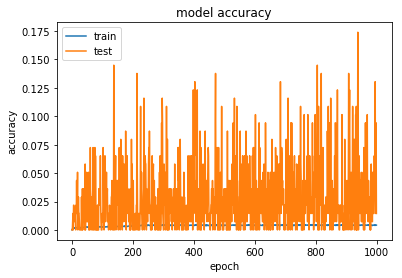

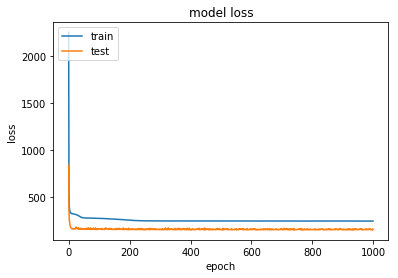

In [52]:
import matplotlib.pyplot as plt

# list all data in history
print(model_hist.history.keys())
# summarize history for mae
plt.plot(model_hist.history['acc'])
plt.plot(model_hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_hist.history['loss'])
plt.plot(model_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [53]:
print(mlp_model.metrics_names)
print(mlp_model.evaluate(X_test,y_test,verbose=0))

['loss', 'mean_absolute_error', 'acc']
[198.13853149414064, 198.13853149414064, 0.02318840579710145]


In [1]:
#load best weights
mlp_model.load_weights('./saved_models/mlp_regression/mlp_regression.best.hdf5')
#compile model
loss = 'mean_absolute_error'
optimizer = 'adam'
metrics=['mae','acc']

i=330
print(X_test[i].reshape(1,-1))
mlp_model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
print("--bestl weights--")
pred = mlp_model.predict(X_test[i].reshape(1,-1))
actual = y_test[i]
print("prediction:",pred)
print("actual:",actual)

NameError: name 'mlp_model' is not defined

In [60]:
mlp_preds = []
mlp_acts = []
mlp_diffs = []
for i in range(len(y_test)):
    mlp_prediction = list(mlp_model.predict(X_test[i].reshape(1,-1)))
    mlp_actual = y_test[i]
    mlp_preds.append(mlp_prediction[0][0])
    mlp_acts.append(mlp_actual)
    mlp_diffs.append(np.abs(mlp_actual-mlp_prediction[0][0]))

(0, 8000)

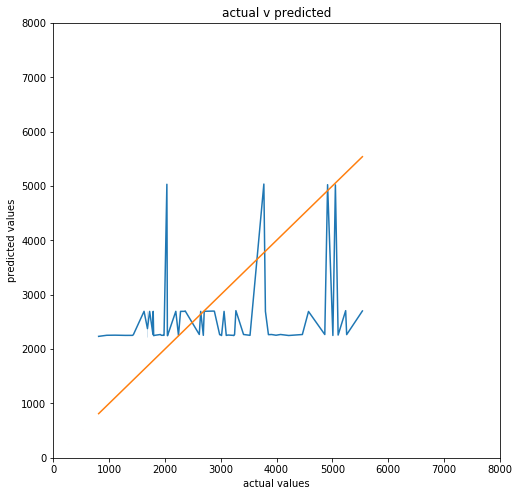

In [61]:
import seaborn as sns
%matplotlib inline

a = list(np.arange(0,8000,100))

f, ax = plt.subplots(1,figsize=(8,8))
sns.lineplot(x=mlp_acts,y=mlp_preds)
sns.lineplot(x=mlp_acts,y=mlp_acts)
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.title('actual v predicted')
                     
ax.set_xlim([0, 8000])
ax.set_ylim([0,8000])

#### To Do: Tune and Evaluate Model

## The Random Forest Regression model gives us the best performance.

Below we will save the model for future use

In [50]:
#prepare model to be saved
import pandas
import numpy as np
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from keras.utils import to_categorical
from pandas import get_dummies
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import pickle

#define evaluation metric
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

#prepare data
df = pd.read_excel('../data_archives/df_processed.xlsx')

#split data into features and labels
X = df[df['WeekTotals']>0][['lat','long','mapped_venue_type','activity_cluster']]
y = df[df['WeekTotals']>0]['WeekTotals']

'''#normalize lat and long
scaler = MinMaxScaler()
scaler.fit(X[['lat','long']])
X[['lat','long']] = scaler.transform(X[['lat','long']])'''

#encode categorical variable
X = pd.get_dummies(X, columns=["mapped_venue_type"])

#test performance for log_transformed y_values
y_log = np.array(np.log(y))

#convert to array
X = np.array(X)
y = np.array(y)

#split data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42,shuffle=True)

# Fit the model on 80%
final_model=RandomForestRegressor(min_samples_leaf=2,criterion='mae', max_depth=10, 
                            max_features=12, min_samples_split=40, n_estimators=100,
                            min_impurity_decrease=.5,random_state=42)
final_model.fit(X_train, y_train)

print("========================================")
print("Finished training")
print("========================================")

print("Best estimator accuracy...")
model_accuracy = evaluate(final_model, X_test, y_test)
print(model_accuracy)

# save the model to disk
filename = './saved_models/FinalModel/Model_CommercialActivityModel.sav'
pickle.dump(final_model, open(filename, 'wb'))

Finished training
Best estimator accuracy...
Model Performance
Average Error: 193.0970 degrees.
Accuracy = 93.04%.
93.0440689376


In [51]:
# some time later...
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.673345879719


In [52]:
def predict_activity_volume(lat,long,program_type):
    import pandas
    import numpy as np
    from sklearn.svm import SVR
    from sklearn.preprocessing import MinMaxScaler
    from keras.utils import to_categorical
    from pandas import get_dummies
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestRegressor
    import pickle
    
    #load model
    filename = './saved_models/FinalModel/Model_CommercialActivityModel.sav'
    loaded_model = pickle.load(open(filename, 'rb'))
    
    #define program map
    program_map = {'automotive':0,
                   'bar':1,
                   'culture_entertainment':2,
                   'education':3,
                   'finance':4,
                   'food':5,
                   'government':6,
                   'grocery':7,
                   'health_wellness':8,
                   'other':9,
                   'professional_services':10,
                   'religous':11,
                   'retail':12,
                   'transportation':13}
    #define cluster map
    cluster_map = {'automotive':0,
                   'bar':3,
                   'culture_entertainment':1,
                   'education':0,
                   'finance':0,
                   'food':1,
                   'government':0,
                   'grocery':1,
                   'health_wellness':0,
                   'other':1,
                   'professional_services':0,
                   'religous':3,
                   'retail':1,
                   'transportation':2}
    
    #structure array
    #set coords
    lat = lat
    long = long
    #look up program index
    program_index = 3 + program_map[program_type]
    #initialize program profile
    venue_profile = [lat,long,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    print(venue_profile)
    #insert 1 at program index to assign program to profile
    venue_profile[program_index] = 1
    print(venue_profile)
    #insert cluster number at index 2 in program profile
    venue_profile[2] = cluster_map[program_type]
    print(venue_profile)
    
    prediction = loaded_model.predict(np.array(venue_profile).reshape(1,-1))
    
    print("Estimated weekly activity volume for a {} venue at ({},{}):".format(program_type,lat,long),prediction[0],"patron visits")
    
    #return prediction
                                      
                                    
    

In [59]:
predict_activity_volume(lat=42.349850,long=-71.059341,program_type='finance')

[42.34985, -71.059341, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[42.34985, -71.059341, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[42.34985, -71.059341, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Estimated weekly activity volume for a finance venue at (42.34985,-71.059341): 4736.03 patron visits


In [ ]:
42.349850, -71.059341